In [8]:
en_user_prompt = """
You are an AI that analyzes PDF documents and outputs results in JSON format.

[Goal]
Scan PDF documents from top to bottom, find all elements, and output their type, location, and content as a JSON array.

[Key Rules]
1. Include all elements: Extract all visual/text elements except headers/footers
2. Process by paragraph: Treat each paragraph as an individual object. Convert lists, quotes, etc. into text and handle them as single paragraph objects.
3. Flag incomplete paragraphs: If the last paragraph on a page doesn't end grammatically, add an "is_incomplete": true flag to that paragraph object.
4. Use correct bbox format: Coordinates should be in the format [x0, y0, x1, y1] (top-left, bottom-right) as a numeric array.

[Output Format]
**When no content:**
```json
{
"data": []
}
```
**When content exists:**
```json
{
 "data": [
  {
    "page_index":  0,
   "type": "sub_title",
   "bbox": [100, 50, 500, 80],
   "content": "Subtitle text"
  },
  {
    "page_index":  0,
   "type": "paragraph",
   "bbox": [100, 90, 500, 250],
   "content": "This paragraph is in the middle of the page and ends normally."

  },
  {
    "page_index":  0,
   "type": "paragraph",
   "bbox": [100, 260, 500, 280],
   "content": "This paragraph is at the end of the page and the sentence doesn't finish, suggesting it continues on the next pa",
   "is_incomplete": true
  },
  {
    "page_index":  1,
   "type": "image",
   "bbox": [150, 290, 450, 410],
   "caption": "Image caption (omit if none)"
  }
]
}
```

[Type Classification]
1. **sub_title**: Section titles
2. **paragraph**: Individual paragraphs, including lists and quotes
3. **table**: Tables (convert to markdown format)
4. **image**: All visual materials (charts, graphs, photos, etc.)
5. **etc**: Elements not fitting above 4 types (equations, code, etc.)

[Processing Steps for each page]
1. Scan PDF from top to bottom
2. Determine each element's type
3. Extract content and bbox
4. Remove grammatically incorrect line breaks in the paragraph.
5. Convert the table to markdown format.
6. Create JSON objects

After processing all pages, Output final JSON within `<json_output>` tags."""

In [45]:
ko_user_prompt = """
당신은 PDF 문서를 분석하여 JSON 형식으로 출력하는 AI입니다.

[Goal]
PDF 문서를 페이지 순서, 그리고 페이지 내 위에서 아래 순서로 스캔하여 모든 요소를 찾고, 아래 [JSON Output Schema]를 엄격히 준수하는 JSON 객체를 생성하세요.

[Key Rules]
1.  단어 중간의 불필요한 줄 바꿈을 제거하여 문법적으로 자연스러운 텍스트를 생성합니다.
2.  각 페이지의 마지막 `paragraph`가 문법적으로 끝나지 않은 경우, `is_incomplete` 필드를 `true`로 설정합니다.
3.  header와 footer는 결과에 포함하지 않습니다.

[JSON Output Schema]
아래 JSON Schema 정의를 반드시 준수하여 최종 결과를 생성해야 합니다.

{
  "$schema": "http://json-schema.org/draft-07/schema#",
  "type": "object",
  "properties": {
    "data": {
      "type": "array",
      "items": {
        "type": "object",
        "properties": {
          "type": { "type": "string", "description": "요소의 유형", "enum": ["sub_title", "paragraph", "table", "image", "etc"] },
          "page_index": { "type": "integer", "description": "요소의 페이지 index"},
          "bbox": { 
            "type": "array",
            "description": "요소의 바운딩 박스 좌표 (x1, y1, x2, y2)",
            "items": { "type": "number" },
            "minItems": 4,
            "maxItems": 4
          },
          "content": { "type": "string", "description": "추출된 텍스트 또는 마크다운 형식의 테이블" },
          "caption": { "type": "string", "description": "이미지나 테이블의 캡션" },
          "is_incomplete": { "type": "boolean", "description": "문장이 문법적으로 미완성일 경우 true" },
          "original_type": { "type": "string", "description": "type이 'etc'일 경우, 원래 요소의 유형" }
        },
        "required": ["type", "page", "bbox"]
      }
    }
  },
  "required": ["data"]
}"""

In [11]:
from google import genai
from google.genai import types
import os

In [8]:
import os
os.path.basename(doc.name)

'농업기술길잡이_배추.pdf'

In [46]:


pdf_path = "/Users/yoonhae/greenlabs/data-labs/experiments/engineering/prototypes/markitdown/pdfs/농업기술길잡이_고추_13-15.pdf"
final_output_filepath = "/Users/yoonhae/greenlabs/data-labs/experiments/engineering/prototypes/markitdown/pdfs/농업기술길잡이_고추_13-15.json"
prompt_text = ko_user_prompt

GEMINI_API_KEY = os.environ.get(
    "GEMINI_API_KEY", ""
)

prompt_parts = []
prompt_parts.append(types.Part.from_text(text=prompt_text))

with open(pdf_path, "rb") as f:
    pdf_bytes = f.read()
    prompt_parts.append(
        types.Part.from_bytes(data=pdf_bytes, mime_type="application/pdf")
    )


contents = [types.Content(role="user", parts=prompt_parts)]
generate_content_config = types.GenerateContentConfig(
    response_mime_type="text/plain",
)
client = genai.Client(api_key=GEMINI_API_KEY)
model_name = "gemini-2.5-flash"
response = client.models.generate_content(
        model=model_name,
        contents=contents,
        config=generate_content_config,
    )
                        


In [ ]:

import json

def format_json_to_text(json_data: dict) -> str:
    """
    PDF 추출 결과 JSON을 RAG 임베딩에 최적화된 
    하나의 마크다운 텍스트로 변환합니다.

    Args:
        json_data (dict): PDF 추출 결과 JSON 데이터.

    Returns:
        str: 컨텍스트가 강화된 전체 마크다운 텍스트.
    """
    if not json_data or 'data' not in json_data or not json_data['data']:
        return ""

    formatted_chunks = []
    
    # 전체 데이터를 순회하며 각 요소를 포매팅된 텍스트 청크로 변환
    for item in json_data['data']:
        chunk_parts = []
        item_type = item.get('type')
        page_index = item.get('page_index', 'N/A')
        content = item.get('content', '')
        caption = item.get('caption')

        # [page_index: N] 태그 추가
        chunk_parts.append(f"[page_index: {page_index}]")

        # 타입에 따라 마크다운 형식 적용
        if item_type == 'sub_title':
            chunk_parts.append(f"## {content}")
        
        elif item_type == 'paragraph':
            chunk_parts.append(content)
        
        elif item_type == 'table':
            if caption:
                chunk_parts.append(f"**표: {caption}**")
            chunk_parts.append(content)
        
        elif item_type == 'image':
            if caption:
                chunk_parts.append(f"**그림: {caption}**")
            # 이미지의 content는 텍스트 설명이므로 '내용:' 태그 추가
            if content:
                chunk_parts.append(f"내용: {content}")
        
        elif item_type == 'etc':
            original_type = item.get('original_type', '기타')
            chunk_parts.append(f"[{original_type.upper()}]: {content}")
        
        else:
            # 정의되지 않은 타입은 content만 추가
            chunk_parts.append(content)
            
        # 완성된 청크를 리스트에 추가
        formatted_chunks.append("\n".join(chunk_parts))

    # 모든 청크를 구분선과 함께 하나의 긴 텍스트로 결합
    return "\n\n---\n\n".join(formatted_chunks)



In [ ]:
import json

raw_text = response.text.replace('"page"', '"page_index"').strip('```').lstrip('json')
j_data = json.loads(raw_text)
# extract_images(j_data)
formatted_text = format_json_to_text(j_data)
print(formatted_text)


In [ ]:
import fitz  # PyMuPDF
doc = fitz.open("/Users/yoonhae/greenlabs/data-labs/experiments/engineering/prototypes/markitdown/pdfs/농업기술길잡이_배추.pdf")
page = doc.load_page(96)

In [14]:

# PDF 파일 생성
output_path = "chunk_output/image_test.pdf"
chunk_doc = fitz.open()
chunk_doc.insert_pdf(doc, from_page=15, to_page=15)
chunk_doc.save(output_path)
chunk_doc.close()
print(f"PDF 파일이 {output_path}에 저장되었습니다.")

PDF 파일이 chunk_output/image_test.pdf에 저장되었습니다.


In [13]:
page.rect

Rect(0.0, 0.0, 453.5429992675781, 666.1420288085938)

In [44]:
import fitz  # PyMuPDF
doc = fitz.open(pdf_path)

In [52]:
images = page.get_images()

In [54]:
images
page.get_image_info()

[{'number': 0,
  'bbox': (129.55294799804688,
   483.9505310058594,
   323.9903869628906,
   587.5780639648438),
  'transform': (194.43743896484375,
   0.0,
   -0.0,
   103.6275405883789,
   129.55294799804688,
   483.9505310058594),
  'width': 895,
  'height': 477,
  'colorspace': 4,
  'cs-name': 'DeviceCMYK',
  'xres': 96,
  'yres': 96,
  'bpc': 8,
  'size': 456846,
  'has-mask': False}]

In [ ]:

import json

def calculate_iou(boxA, boxB):
    """
    두 경계 상자의 IoU(Intersection over Union)를 계산합니다.
    """
    # 교차하는 사각형의 좌표를 결정합니다.
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # 교차 영역의 넓이를 계산합니다.
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # 각 사각형의 넓이를 계산합니다.
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # IoU를 계산합니다. (합집합 넓이 = A넓이 + B넓이 - 교집합 넓이)
    union_area = float(boxAArea + boxBArea - interArea)
    iou = interArea / union_area if union_area != 0 else 0

    return iou

item = {
    "page_index": 38,
    "bbox": [70, 70, 140, 140],
    "caption": "<그림 2-5> 상자를 이용한 수확 및 출하",
    "type": "image",
    "content": "산이 있는 논에서 상자에 배추를 담는 사진"
}


def save_image_from_pdf(image_item: dict, doc: fitz.Document, output_dir: str = "output/imgs", iou_threshold: float = 0.9):
    """
    JSON 결과와 PDF 문서를 기반으로 이미지를 저장합니다.

    JSON의 bbox와 fitz가 추출한 이미지의 bbox 간 IoU를 비교하여, 임계값 이상이면
    fitz가 직접 추출한 이미지를 저장하고, 그렇지 않으면 JSON의 bbox를 이용해 페이지를 크롭하여 저장합니다.

    Args:
        image_item (dict): JSON 데이터에서 추출한 이미지 요소.
                           {'page_index': int, 'bbox': [x0, y0, x1, y1], ...}
        doc (fitz.Document): PyMuPDF 문서 객체.
        output_dir (str): 이미지를 저장할 디렉토리 경로.
        iou_threshold (float): 이미지 일치 여부를 판단할 IoU 임계값.
    """
    try:
        page_index = image_item.get("page_index")
        if page_index is None:
            print(f"경고: 이미지 아이템에 'page_index'가 없어 건너뜁니다.")
            return

        json_bbox = image_item.get("bbox")
        if not json_bbox:
            print(f"경고: {page_index} 페이지의 이미지 아이템에 'bbox'가 없어 건너뜁니다.")
            return

        page = doc.load_page(page_index)
        # 이미지 직접 추출을 위해 xref=True 옵션 사용
        image_infos = page.get_image_info(xrefs=True)

        best_match = None
        max_iou = 0

        # 페이지 내 모든 이미지와 IoU를 계산하여 가장 일치하는 이미지 탐색
        for img_info in image_infos:
            fitz_bbox = img_info['bbox']
            iou = calculate_iou(json_bbox, fitz_bbox)
            if iou > max_iou:
                max_iou = iou
                best_match = img_info

        # 이미지를 저장할 디렉토리 생성
        os.makedirs(output_dir, exist_ok=True)

        # 캡션을 이용해 파일명 생성, 없으면 bbox 정보 사용
        caption = image_item.get('caption', '').strip()
        if caption:
            # 파일명으로 부적합한 문자 제거
            safe_caption = "".join([c.replace(" ", "_") for c in caption if c.isalnum() or c in (' ', '-')]).rstrip()
            img_filename = f"page_{page_index}_{safe_caption[:30]}.png"
        else:
            img_filename = f"page_{page_index}_bbox_{'_'.join(map(str, map(int, json_bbox)))}.png"

        img_path = os.path.join(output_dir, img_filename)

        img_bytes = None
        if max_iou > iou_threshold and best_match:
            print(f"{page_index} 페이지에서 IoU {max_iou:.2f}로 일치하는 이미지를 찾았습니다. 직접 추출합니다.")
            # xref를 사용하여 이미지 데이터 직접 추출
            img_data = doc.extract_image(best_match['xref'])
            img_bytes = img_data["image"]
        else:
            print(f"일치하는 이미지를 찾지 못했습니다 (최대 IoU: {max_iou:.2f}). {page_index} 페이지를 bbox로 크롭합니다.")
            # bbox를 사용하여 페이지 크롭 (고해상도 추출을 위해 dpi 설정)
            rect = fitz.Rect(json_bbox)
            pix = page.get_pixmap(clip=rect, dpi=200)
            img_bytes = pix.tobytes("png")

        if img_bytes:
            with open(img_path, "wb") as f:
                f.write(img_bytes)
            print(f"이미지를 {img_path}에 저장했습니다.")

    except Exception as e:
        print(f"{page_index} 페이지의 이미지 처리 중 오류 발생: {e}")

일치하는 이미지를 찾지 못했습니다 (최대 IoU: 0.00). 38 페이지를 bbox로 크롭합니다.
이미지를 output/imgs/page_38_그림 2-5 상자를 이용한 수확 및 출하.png에 저장했습니다.


In [ ]:
# en
response

In [ ]:
GenerateContentResponseUsageMetadata(
    candidates_token_count=2733,
    prompt_token_count=1433,
    prompt_tokens_details=[
      ModalityTokenCount(
        modality=<MediaModality.TEXT: 'TEXT'>,
        token_count=659
      ),
      ModalityTokenCount(
        modality=<MediaModality.DOCUMENT: 'DOCUMENT'>,
        token_count=774
      ),
    ],
    thoughts_token_count=5939,
    total_token_count=10105
  )

usage_metadata=GenerateContentResponseUsageMetadata(
    candidates_token_count=3052,
    prompt_token_count=1323,
    prompt_tokens_details=[
      ModalityTokenCount(
        modality=<MediaModality.TEXT: 'TEXT'>,
        token_count=549
      ),
      ModalityTokenCount(
        modality=<MediaModality.DOCUMENT: 'DOCUMENT'>,
        token_count=774
      ),
    ],
    thoughts_token_count=7618,
    total_token_count=11993
  )

In [60]:
doc.close()

NameError: name 'doc' is not defined

In [61]:
import fitz  # PyMuPDF

doc = fitz.open("/Users/yoonhae/greenlabs/data-labs/experiments/engineering/pipelines/pdf-to-opensearch/pdfs/농업기술길잡이_벼.pdf")

In [62]:
page = doc.load_page(12)

In [147]:
page.rect

Rect(0.0, 0.0, 453.5429992675781, 666.1420288085938)

In [64]:
dics = page.get_text('dict')

In [ ]:
for b in dics['blocks']:
    lines = b.get('lines', [])
    # lines.sort(key=lambda l: (l['bbox'][1], l['bbox'][0]))
    for l in  lines:
        print('---')
        for s in l.get('spans', []):
            print(s['text'])
            print(s['bbox'])
            print(s["font"], s["size"])

In [149]:
import json

with open('/Users/yoonhae/greenlabs/data-labs/experiments/engineering/pipelines/pdf-to-opensearch/output_v2/debug/all_document_elements.json', 'r') as f:
    all_document_elements = json.load(f)

from fitz import Rect
for element in all_document_elements:
    if element.get('bbox'):
        element['bbox'] = eval(element['bbox'])
    if element.get('content'):
        if isinstance(element['content'], dict) and element['content'].get('drawing_rect'):
            element['content']['drawing_rect'] = eval(element['content']['drawing_rect'])

In [150]:
with open('/Users/yoonhae/greenlabs/data-labs/experiments/engineering/pipelines/pdf-to-opensearch/output_v2/debug/doc_metadata.json', 'r') as f:
    doc_meta = json.load(f)

doc_meta

{'font_info': {'plain_size': 9.899495124816895,
  'plain_font': 'KoPubWorldBatangPL',
  'plain_height': 15.019989013671875},
 'header_footer_info': {'header_y_max': 56.77025604248047,
  'footer_y_min': 606.9903564453125,
  'left_margin_x_max': 38.188899993896484,
  'right_margin_x_min': 419.5132141113281}}

In [ ]:
pages_to_process = {}
for element in all_document_elements:
    if element['type'] in ['image_meta', 'drawing_meta', 'table_caption', 'figure_caption']:
        page_number = element['page_index']
        if page_number not in pages_to_process:
            pages_to_process[page_number] = []
        pages_to_process[page_number].append(element)


In [152]:
# 공통 유틸리티 import
from utils import (
    PDFProcessorConfig, S3Manager, CAPTION_PATTERNS, 
    get_safe_filename, generate_cdn_url, save_json_file, save_markdown_file,
    ensure_directory_exists, safe_save_pixmap
)
import os
import importlib
import text_based_converter_refactored
importlib.reload(text_based_converter_refactored)
from text_based_converter_refactored import TextBasedConverter


self = TextBasedConverter()
self._doc_metadata = doc_meta

#### 페이지별 처리 영역

In [ ]:
page_number = 150
page_elements = pages_to_process[page_number]

page = doc.load_page(page_number)
page_num = page_number + 1

print(f"Extracting media content from page {page_num}/{len(doc)}...")

# 페이지의 요소들을 타입별로 분류
images = [el for el in page_elements if el['type'] == 'image_meta']
drawings = [el for el in page_elements if el['type'] == 'drawing_meta']
table_captions = [el for el in page_elements if el['type'] == 'table_caption']
figure_captions = [el for el in page_elements if el['type'] == 'figure_caption']

# 같은 페이지의 etc 텍스트 수집 (y축 레이블 텍스트 포함)
page_etc_rects = []
page_text_rects = []
for element in all_document_elements:
    if (element['page_index'] == page_number and
        element.get('content')):
        if element['type'] in ('etc', 'title'):
            page_etc_rects.append(element['bbox'])
        else:
            page_text_rects.append(element['bbox'])

Extracting media content from page 151/184...


#### 이미지 처리

In [ ]:

# 2. 이미지 처리
for image_element in images:
    pix = None

    try:
        img_info = image_element['content']['img_info']
        img_xref = image_element['content']['img_xref']
        bbox = image_element['bbox']
        print(bbox.width, bbox.height, bbox)
        
        # 가장 가까운 figure caption 찾기
        page_figure_captions = [c for c in figure_captions]
        if page_figure_captions:
            closest_caption = min(
                page_figure_captions,
                key=lambda c: self._calculate_closest_distance_to_outline(c['bbox'], bbox)
            )
            caption_text = closest_caption['content']['text']
        else:
            caption_text = "NO CAPTION"
            if not(0.1 < bbox.width / bbox.height < 10):
                continue # 종횡비 이상치 체크
        
        # 파일 저장
        safe_caption = get_safe_filename(caption_text, 30)
        unique_filename = f"page_{page_number}_pic_{safe_caption}_{img_xref}.png"
        output_path = os.path.join(self.config.output_dir, 'imgs_debug', unique_filename)
        
        ensure_directory_exists(os.path.dirname(output_path))

        need_clip = False
        clip_rect = fitz.Rect(bbox)
        for etc_bbox in page_etc_rects:
            if etc_bbox.intersects(bbox):
                need_clip = True
                clip_rect.include_rect(etc_bbox)
                
        if need_clip:
            PADDING = 3
            clip_rect.x0 -= PADDING
            clip_rect.y0 -= PADDING
            clip_rect.x1 += PADDING
            clip_rect.y1 += PADDING
            clip_rect = clip_rect & page.rect
            pix = page.get_pixmap(matrix=fitz.Matrix(2, 2), clip=clip_rect)
        else:
            # 이미지 영역 내에 text 가 있는지 체크해서 있으면 캡쳐링으로 저장하도록 수정해야함.!!!!
            pix = fitz.Pixmap(doc, img_xref)
        
        if safe_save_pixmap(pix, output_path):
            print("***", output_path)


        
    except (ValueError, RuntimeError) as e:
        print(f"[Warning] Page {page_num}: Failed to process image xref {img_info[0]}. Error: {e}")

196.794189453125 132.50759887695312 Rect(128.37454223632812, 289.990966796875, 325.1687316894531, 422.4985656738281)
*** output/imgs_debug/page_179_pic_그림_5-1_감의_탄저병_증상_579.png


In [120]:
drawing

{'type': 'drawing_meta',
 'page_index': 198,
 'bbox': Rect(83.62200164794922, 298.9870300292969, 368.60589599609375, 465.5709228515625),
 'content': {'drawing_rect': Rect(83.62200164794922, 298.9870300292969, 368.60589599609375, 465.5709228515625),
  'drawing_id': 1},
 'sort_key': [198, 298.9870300292969]}

In [ ]:
if figure_captions:
    # 이미 처리된 이미지들과 겹치지 않는 drawing들 필터링
    available_drawings = []
    
    for drawing in drawings:
        if not(0.15 < drawing["bbox"].width / drawing["bbox"].height < 9.5):
            continue # 종횡비 이상치 체크
        available_drawings.append(drawing)
    
    for i, caption_element in enumerate(figure_captions):
        if not available_drawings:
            break
            
        caption_bbox = caption_element['bbox']
        caption_text = caption_element['content']['text']
        print(caption_text)
        
        # 스마트한 차트 선택 + 축 레이블 병합
        drawing_rects = [d['content']['drawing_rect'] for d in available_drawings]
        
        # 디버깅 모드에서 drawing 분류 검증
        debug_mode = os.environ.get("PDF_CONVERTER_DEBUG", "false").lower() == "true"
        if debug_mode:
            print(f"\n🔍 Processing caption: '{caption_text}' on page {page_number + 1}")
            classification_stats = self._validate_drawing_classification(drawing_rects, page.rect)
            print(f"Available drawings for chart selection: {len(drawing_rects)}")
            print(f"Available etc texts for axis labels: {len(page_etc_rects)}")
        
        closest_drawing = self._find_chart_with_axis_merge(
            caption_bbox, drawing_rects, page.rect, etc_text_rects=page_etc_rects,
            text_rects=page_text_rects
        )
        
        if not closest_drawing:
            continue
        
        # 캡션과 병합된 최종 영역 계산
        PADDING = 3
        merged_bbox = fitz.Rect(closest_drawing)
        merged_bbox.include_rect(caption_bbox)
        merged_bbox.x0 -= PADDING
        merged_bbox.y0 -= PADDING
        merged_bbox.x1 += PADDING
        merged_bbox.y1 += PADDING
        
        # 파일 저장
        safe_caption = get_safe_filename(caption_text, 30)
        unique_filename = f"page_{page_number}_chart_{safe_caption}_{i}.png"
        output_path = os.path.join(self.config.output_dir, "imgs_debug", unique_filename)
        
        try:
            clip_rect = merged_bbox & page.rect
            pix = page.get_pixmap(matrix=fitz.Matrix(2, 2), clip=clip_rect)
            if safe_save_pixmap(pix, output_path):
                print("***", output_path)
            
            
        except Exception as e:
            print(f"[Warning] Page {page_num}: Failed to save chart for caption '{caption_text}'. Error: {e}")


<그림 6-21> 시기별 황색 끈끈이 트랩에 포획된 총채벌레 밀도(2009년, 2010년, 2011년, 2012년)
*** output/imgs_debug/page_150_chart_그림_6-21_시기별_황색_끈끈이_트랩에_포획된_총채벌_0.png
<그림 6-22> 과일의 시기별 생충수와 피해 정도(위) 및


In [13]:
from text_based_converter_refactored import TextBasedConverter

test = TextBasedConverter()
test._doc_metadata = doc_meta



📊 Text analysis summary:
  - Total text blocks found: 6859
  - Plain text blocks: 3571
  - Title blocks: 645
  - ETC blocks: 2643
  - Final included text elements: 4083
  - Pages with text: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,

6678

In [61]:
page_rect

Rect(0.0, 0.0, 453.5429992675781, 666.1420288085938)

In [51]:
import fitz
import os

class part_class:
    def _merge_drawings_with_text_blocks(self, drawing: fitz.Rect, text_blocks: list, 
                                        padding: int = 10, only_bottom_merge: bool = False) -> fitz.Rect:
        """드로잉 Rect와 텍스트 블록을 병합하는 함수"""
        checked_rect = fitz.Rect(
            drawing.x0 - padding, drawing.y0 - padding, 
            drawing.x1 + padding, drawing.y1 + padding
        )
        
        for block in text_blocks:
            text_rect = fitz.Rect(
                block[0] - padding, block[1] - padding, 
                block[2] + padding, block[3] + padding
            )
            if checked_rect.intersects(text_rect):
                if only_bottom_merge:
                    if text_rect.y1 > drawing.y1:
                        checked_rect.y1 = text_rect.y1
                else:
                    checked_rect.include_rect(text_rect)

        return checked_rect

    def _remove_overlapping_bboxes(self, main_bboxs: list, ref_targets: list) -> list:
        """이미 추출된 요소의 bbox 영역에 속한 drawings 제거"""
        if not ref_targets or not main_bboxs:
            return main_bboxs

        filtered_drawings = []
        for drawing in main_bboxs:
            is_contained = False
            for element_bbox in ref_targets:
                # drawing이 이미 추출된 요소의 bbox 내에 포함되어 있는지 확인
                if element_bbox.contains(drawing):
                    is_contained = True
                    break
            if not is_contained:
                filtered_drawings.append(drawing)
        
        return filtered_drawings

    def _calculate_closest_distance_to_outline(self, caption_bbox: fitz.Rect, object_bbox: fitz.Rect) -> float:
        """캡션이 객체의 어느 위치에 있는지 파악하고, 객체 outline 기준 가장 가까운 거리를 계산"""
        caption_center_x = (caption_bbox.x0 + caption_bbox.x1) / 2
        caption_center_y = (caption_bbox.y0 + caption_bbox.y1) / 2
        
        obj_left, obj_top, obj_right, obj_bottom = object_bbox

        if caption_center_x < obj_left:
            if caption_center_y < obj_top:
                distance = ((obj_left - caption_center_x)**2 + (obj_top - caption_center_y)**2)**0.5
            elif caption_center_y > obj_bottom:
                distance = ((obj_left - caption_center_x)**2 + (caption_center_y - obj_bottom)**2)**0.5
            else:
                distance = obj_left - caption_center_x
        elif caption_center_x > obj_right:
            if caption_center_y < obj_top:
                distance = ((caption_center_x - obj_right)**2 + (obj_top - caption_center_y)**2)**0.5
            elif caption_center_y > obj_bottom:
                distance = ((caption_center_x - obj_right)**2 + (caption_center_y - obj_bottom)**2)**0.5
            else:
                distance = caption_center_x - obj_right
        else:
            if caption_center_y < obj_top:
                distance = obj_top - caption_center_y
            elif caption_center_y > obj_bottom:
                distance = caption_center_y - obj_bottom
            else:
                distance = 0
        
        return distance

    def _classify_drawing_type(self, drawing: fitz.Rect, page_rect: fitz.Rect, all_drawings: list = None) -> str:
        """drawing의 유형을 분류 (메인 차트 vs 범례 vs 축)"""
        area = drawing.width * drawing.height
        page_area = page_rect.width * page_rect.height
        area_ratio = area / page_area if page_area > 0 else 0
        
        # 종횡비 계산
        aspect_ratio = drawing.width / drawing.height if drawing.height > 0 else 0
        
        # 기본 크기 임계값들
        min_width = 20
        min_height = 20
        
        # 디버깅 정보
        debug_mode = os.environ.get("PDF_CONVERTER_DEBUG", "false").lower() == "true"
        if debug_mode:
            print(f"  Classifying drawing: {drawing}")
            print(f"    Area ratio: {area_ratio:.4f}, Aspect ratio: {aspect_ratio:.2f}")
            print(f"    Width: {drawing.width:.1f}, Height: {drawing.height:.1f}")
        
        # 1. 명확한 축/범례 패턴 (우선 분류)
        if (area_ratio < 0.003 or  # 매우 작은 면적
            aspect_ratio > 20 or aspect_ratio < 0.05 or  # 극단적인 종횡비
            drawing.width < min_width or drawing.height < min_height):  # 절대 크기가 너무 작음
            if debug_mode:
                print(f"    → axis_or_legend (small/extreme)")
            return "axis_or_legend"
        
        # 2. 상대적 크기 고려 (all_drawings가 제공된 경우)
        if all_drawings:
            # 모든 drawing 중에서 상위 크기에 속하는지 확인
            all_areas = [d.width * d.height for d in all_drawings if d != drawing]
            if all_areas:
                larger_count = sum(1 for area_val in all_areas if area_val > area)
                relative_rank = larger_count / len(all_areas) if all_areas else 0
                
                if debug_mode:
                    print(f"    Relative rank: {relative_rank:.2f} (top {relative_rank*100:.1f}%)")
                
                # 상위 50% 안에 들고 적절한 종횡비를 가지면 메인 차트 후보
                if relative_rank < 0.5 and 0.2 < aspect_ratio < 8.0:
                    if debug_mode:
                        print(f"    → main_chart (relative size)")
                    return "main_chart"
        
        # 3. 절대 기준으로 메인 차트 판단 (더 관대한 기준)
        if (area_ratio > 0.01 and  # 페이지의 1% 이상 (기존 0.02에서 완화)
            0.2 < aspect_ratio < 8.0 and  # 종횡비 범위 확장 (기존 0.3~4.0에서 확장)
            drawing.width > min_width * 2 and  # 최소 너비
            drawing.height > min_height * 2):  # 최소 높이
            if debug_mode:
                print(f"    → main_chart (absolute criteria)")
            return "main_chart"
        
        # 4. 기타 경우
        if debug_mode:
            print(f"    → unknown")
        return "unknown"

    def _score_chart_candidate(self, caption_bbox: fitz.Rect, drawing: fitz.Rect, 
                              drawing_type: str, page_rect: fitz.Rect) -> float:
        """차트 후보의 적합성 점수를 계산"""
        distance = self._calculate_closest_distance_to_outline(caption_bbox, drawing)
        area = drawing.width * drawing.height
        
        # 캡션이 drawing의 아래쪽에 있는지 확인 (일반적인 차트 구조)
        caption_center_y = (caption_bbox.y0 + caption_bbox.y1) / 2
        is_below = caption_center_y > drawing.y1
        
        # 가로폭 유사성 확인
        width_similarity = min(caption_bbox.width, drawing.width) / max(caption_bbox.width, drawing.width)
        
        # 종합 점수 계산
        score = 0
        
        # 거리 점수 (가까울수록 높음, 최대 100점)
        score += max(0, 100 - distance)
        
        # 면적 점수 (적당한 크기가 좋음, 최대 50점)
        page_area = page_rect.width * page_rect.height
        area_ratio = area / page_area if page_area > 0 else 0
        if 0.01 < area_ratio < 0.3:
            score += 50 * min(area_ratio / 0.1, 1.0)
        
        # 위치 관계 점수 (캡션이 아래에 있으면 +30점)
        if is_below:
            score += 30
        
        # 가로폭 유사성 점수 (최대 20점)
        score += width_similarity * 20
        
        # 타입별 보너스 점수
        if drawing_type == "main_chart":
            score += 50  # 메인 차트로 분류되면 큰 보너스
        elif drawing_type == "axis_or_legend":
            score -= 30  # 축이나 범례로 분류되면 감점
        
        return score

    def _find_chart_components_for_caption(self, caption_bbox: fitz.Rect, drawings: list, 
                                         page_rect: fitz.Rect = None) -> fitz.Rect:
        """캡션을 기준으로 스마트한 차트 영역 선택"""
        if not drawings:
            return None
        
        # 기본 페이지 rect 설정 (전달되지 않은 경우)
        if page_rect is None:
            # drawings로부터 대략적인 페이지 크기 추정
            all_x = [d.x0 for d in drawings] + [d.x1 for d in drawings]
            all_y = [d.y0 for d in drawings] + [d.y1 for d in drawings]
            page_rect = fitz.Rect(min(all_x), min(all_y), max(all_x), max(all_y))
        
        # 각 drawing을 분류하고 점수 계산
        candidates = []
        for drawing in drawings:
            drawing_type = self._classify_drawing_type(drawing, page_rect, drawings)
            score = self._score_chart_candidate(caption_bbox, drawing, drawing_type, page_rect)
            distance = self._calculate_closest_distance_to_outline(caption_bbox, drawing)
            
            candidates.append({
                'drawing': drawing,
                'type': drawing_type,
                'score': score,
                'distance': distance,
                'area': drawing.width * drawing.height
            })
        
        # 점수 기준으로 정렬 (높은 점수가 먼저)
        candidates.sort(key=lambda x: x['score'], reverse=True)
        
        # 디버깅 정보 출력 (개발 모드에서만)
        debug_mode = os.environ.get("PDF_CONVERTER_DEBUG", "false").lower() == "true"
        if debug_mode and len(candidates) > 1:
            print(f"Chart selection for caption: {caption_bbox}")
            for i, cand in enumerate(candidates[:3]):  # 상위 3개만 출력
                print(f"  {i+1}. Type: {cand['type']}, Score: {cand['score']:.1f}, "
                      f"Distance: {cand['distance']:.1f}, Area: {cand['area']:.0f}")
        
        # 최고 점수의 drawing 선택
        if candidates:
            best_candidate = candidates[0]
            
            # 최고 점수가 너무 낮으면 (< 50) 기존 방식으로 폴백
            if best_candidate['score'] < 50:
                if debug_mode:
                    print(f"  Low score ({best_candidate['score']:.1f}), using fallback method")
                return min(drawings, key=lambda d: self._calculate_closest_distance_to_outline(caption_bbox, d))
            
            return best_candidate['drawing']
        
        return None

    def _merge_chart_with_axis_labels(self, main_chart: fitz.Rect, all_drawings: list, 
                                    page_rect: fitz.Rect, expansion_ratio: float = 0.3) -> fitz.Rect:
        """
        메인 차트 영역에 관련된 x축, y축 레이블들을 병합
        
        Args:
            main_chart: 메인 차트 영역
            all_drawings: 모든 드로잉 영역들
            page_rect: 페이지 전체 영역
            expansion_ratio: 축 레이블 검색 범위 확장 비율
            
        Returns:
            축 레이블이 병합된 확장된 차트 영역
        """
        if not all_drawings:
            return main_chart
        
        # 메인 차트 주변 검색 영역 설정
        chart_width = main_chart.width
        chart_height = main_chart.height
        
        # x축 레이블 검색 영역 (차트 아래쪽)
        x_axis_search = fitz.Rect(
            main_chart.x0 - chart_width * expansion_ratio,
            main_chart.y1,  # 차트 아래부터
            main_chart.x1 + chart_width * expansion_ratio,
            main_chart.y1 + chart_height * 0.5  # 차트 높이의 50%까지
        )
        
        # y축 레이블 검색 영역 (차트 왼쪽)
        y_axis_search = fitz.Rect(
            main_chart.x0 - chart_width * 0.5,  # 차트 왼쪽으로 차트 폭의 50%까지
            main_chart.y0 - chart_height * expansion_ratio,
            main_chart.x0,  # 차트 왼쪽까지
            main_chart.y1 + chart_height * expansion_ratio
        )
        
        # 페이지 경계 내로 제한
        x_axis_search = x_axis_search & page_rect
        y_axis_search = y_axis_search & page_rect
        
        # 축 레이블 후보들 찾기
        axis_candidates = []
        
        for drawing in all_drawings:
            # 메인 차트와 겹치는 것은 제외
            if drawing == main_chart or main_chart.intersects(drawing):
                continue
                
            drawing_type = self._classify_drawing_type(drawing, page_rect, all_drawings)
            
            # x축 영역에 있는 축/범례 요소들
            if x_axis_search.intersects(drawing) and drawing_type == "axis_or_legend":
                # x축 레이블은 주로 가로로 길고 차트 아래에 위치
                aspect_ratio = drawing.width / drawing.height if drawing.height > 0 else 0
                if aspect_ratio > 2.0:  # 가로로 긴 형태
                    axis_candidates.append(('x_axis', drawing))
            
            # y축 영역에 있는 축/범례 요소들  
            elif y_axis_search.intersects(drawing) and drawing_type == "axis_or_legend":
                # y축 레이블은 주로 세로로 길고 차트 왼쪽에 위치
                aspect_ratio = drawing.width / drawing.height if drawing.height > 0 else 0
                if aspect_ratio < 0.5:  # 세로로 긴 형태
                    axis_candidates.append(('y_axis', drawing))
        
        # 병합된 영역 계산
        merged_chart = fitz.Rect(main_chart)
        
        for axis_type, axis_drawing in axis_candidates:
            merged_chart.include_rect(axis_drawing)
            
        # 디버깅 정보 출력
        debug_mode = os.environ.get("PDF_CONVERTER_DEBUG", "false").lower() == "true"
        if debug_mode and axis_candidates:
            print(f"    Merging axis labels: {len(axis_candidates)} found")
            for axis_type, axis_drawing in axis_candidates:
                print(f"      {axis_type}: {axis_drawing}")
            print(f"    Original chart: {main_chart}")
            print(f"    Expanded chart: {merged_chart}")
        
        return merged_chart

    def _validate_drawing_classification(self, drawings: list, page_rect: fitz.Rect) -> dict:
        """drawing 분류 결과를 검증하고 통계를 반환"""
        if not drawings:
            return {"main_charts": 0, "axis_or_legend": 0, "unknown": 0, "total": 0}
        
        classification_stats = {"main_charts": 0, "axis_or_legend": 0, "unknown": 0, "total": len(drawings)}
        
        debug_mode = os.environ.get("PDF_CONVERTER_DEBUG", "false").lower() == "true"
        if debug_mode:
            print(f"\n=== Drawing Classification Validation ===")
            print(f"Total drawings to classify: {len(drawings)}")
        
        for i, drawing in enumerate(drawings):
            drawing_type = self._classify_drawing_type(drawing, page_rect, drawings)
            classification_stats[drawing_type + "s"] = classification_stats.get(drawing_type + "s", 0) + 1
            
            if debug_mode:
                area = drawing.width * drawing.height
                page_area = page_rect.width * page_rect.height
                area_ratio = area / page_area if page_area > 0 else 0
                aspect_ratio = drawing.width / drawing.height if drawing.height > 0 else 0
                
                print(f"Drawing {i+1}: {drawing}")
                print(f"  Type: {drawing_type}")
                print(f"  Area ratio: {area_ratio:.4f}, Aspect ratio: {aspect_ratio:.2f}")
                print(f"  Size: {drawing.width:.1f} x {drawing.height:.1f}")
        
        if debug_mode:
            print(f"\nClassification Summary:")
            print(f"  Main charts: {classification_stats.get('main_charts', 0)}")
            print(f"  Axis/Legend: {classification_stats.get('axis_or_legends', 0)}")
            print(f"  Unknown: {classification_stats.get('unknowns', 0)}")
            print(f"==========================================\n")
        
        return classification_stats

    def _analyze_horizontal_chart_relationship(self, main_chart: fitz.Rect, candidate_chart: fitz.Rect) -> float:
        """수평으로 나란히 있는 차트들의 관계 점수 계산"""
        score = 0
        
        # 1. 수직 정렬 점수 (y좌표가 비슷할수록 높은 점수)
        y_center_diff = abs((main_chart.y0 + main_chart.y1)/2 - (candidate_chart.y0 + candidate_chart.y1)/2)
        y_alignment_score = max(0, 100 - y_center_diff)
        
        # 2. 크기 유사도 점수
        height_ratio = min(main_chart.height, candidate_chart.height) / max(main_chart.height, candidate_chart.height)
        width_ratio = min(main_chart.width, candidate_chart.width) / max(main_chart.width, candidate_chart.width)
        size_similarity_score = (height_ratio + width_ratio) * 50  # 최대 100점
        
        # 3. 수평 거리 점수 (적절한 거리에 있을 때 높은 점수)
        # 좌우 배치에 관계없이 가장 가까운 거리 계산
        horizontal_distance = min(
            abs(candidate_chart.x0 - main_chart.x1),  # candidate가 main 오른쪽에 있는 경우
            abs(candidate_chart.x1 - main_chart.x0)   # candidate가 main 왼쪽에 있는 경우
        )
        ideal_distance = main_chart.width * 0.2  # 차트 너비의 20%를 이상적인 거리로 가정
        distance_score = max(0, 100 - abs(horizontal_distance - ideal_distance))
        
        # 종합 점수 계산 (각 요소별 가중치 적용)
        score = (y_alignment_score * 0.4 +  # 수직 정렬이 가장 중요
                size_similarity_score * 0.3 +  # 크기 유사도도 중요
                distance_score * 0.3)  # 수평 거리도 고려
        
        return score
    
    def _merge_related_charts(self, main_chart: fitz.Rect, all_drawings: list, page_rect: fitz.Rect) -> fitz.Rect:
        """메인 차트와 관련된 다른 차트들을 병합"""
        if not all_drawings:
            return main_chart
            
        merged_chart = fitz.Rect(main_chart)  # 초기 영역은 메인 차트
        used_drawings = {main_chart}  # 이미 사용된 drawing 추적
        
        # 1. 후보 차트들 찾기
        candidates = []
        for drawing in all_drawings:
            if drawing in used_drawings:
                continue
                
            # 차트 타입 확인 (메인 차트와 비슷한 크기의 것들만 고려)
            if self._classify_drawing_type(drawing, page_rect) == "main_chart":
                # 수평 관계 점수 계산
                score = self._analyze_horizontal_chart_relationship(main_chart, drawing)
                if score > 70:  # 임계값 이상인 경우만 후보로 선정
                    candidates.append((drawing, score))
        
        # 2. 점수 기준으로 정렬
        candidates.sort(key=lambda x: x[1], reverse=True)
        
        # 3. 양방향으로 병합 (왼쪽과 오른쪽 모두)
        debug_mode = os.environ.get("PDF_CONVERTER_DEBUG", "false").lower() == "true"
        
        for candidate, score in candidates:
            # 이미 병합된 영역과 인접한지 확인 (왼쪽 또는 오른쪽)
            is_adjacent = (
                candidate.x0 > merged_chart.x1 or  # 오른쪽에 인접
                candidate.x1 < merged_chart.x0     # 왼쪽에 인접
            )
            
            if is_adjacent:
                if debug_mode:
                    position = "right" if candidate.x0 > merged_chart.x1 else "left"
                    print(f"    Merging {position} chart: {candidate} (score: {score:.1f})")
                
                # 중간 영역도 포함하여 병합
                merged_chart.include_rect(candidate)
                used_drawings.add(candidate)

        # 4. 다 병합하고 나서 다른 차트들과 교차되는 영역 체크하기
        for r in all_drawings:
            if merged_chart not in used_drawings:
                if merged_chart.intersects(r):
                    merged_chart.include_rect(r)
                    used_drawings.add(r)
        
        return merged_chart

    def _find_chart_with_axis_merge(self, caption_bbox: fitz.Rect, drawings: list, 
                                  page_rect: fitz.Rect = None) -> fitz.Rect:
        """
        캡션을 기준으로 차트를 찾고 관련된 축 레이블들과 병합
        """
        # 1. 메인 차트 영역 찾기
        main_chart = self._find_chart_components_for_caption(caption_bbox, drawings, page_rect)
        if not main_chart:
            return None
        
        # 2. 축 레이블들과 병합
        merged_chart = self._merge_chart_with_axis_labels(main_chart, drawings, page_rect or fitz.Rect(0, 0, 600, 800))
        

        # 3. 관련된 차트들과 병합
        final_chart = self._merge_related_charts(merged_chart, drawings, page_rect or fitz.Rect(0, 0, 600, 800))
        return final_chart

test = part_class()
page_rect = page.rect
caption_bbox =fitz.Rect([144.73019409179688,
  226.85372924804688,
  303.14544677734375,
  236.1017303466797])
drawings = page.cluster_drawings()

test._find_chart_with_axis_merge(caption_bbox, drawings, page_rect or fitz.Rect(0, 0, 600, 800))

Rect(126.99210357666016, 74.74102783203125, 334.48809814453125, 203.396240234375)

In [50]:
drawings = page.cluster_drawings()
for d in drawings:
    print(d.width, 'x', d.height, d)

23.311004638671875 x 6.8699951171875 Rect(247.71499633789062, 63.3310546875, 271.0260009765625, 70.2010498046875)
207.4959945678711 x 100.3094482421875 Rect(126.99210357666016, 74.74102783203125, 334.48809814453125, 175.05047607421875)
10.772003173828125 x 106.01602172851562 Rect(90.05400085449219, 85.23699951171875, 100.82600402832031, 191.25302124023438)
54.49000549316406 x 7.72430419921875 Rect(140.281494140625, 195.67193603515625, 194.77149963378906, 203.396240234375)
54.49000549316406 x 7.72430419921875 Rect(208.38389587402344, 195.67193603515625, 262.8739013671875, 203.396240234375)
54.489990234375 x 7.72430419921875 Rect(276.0610046386719, 195.67193603515625, 330.5509948730469, 203.396240234375)


In [ ]:
page.get_text('blocks')

In [38]:
for r in rects:
    print(r.width, 'x', r.height, r)

22.177978515625 x 13.67300033569336 Rect(296.7055969238281, 39.93851089477539, 318.8835754394531, 53.61151123046875)
45.35399627685547 x 11.3389892578125 Rect(114.8030014038086, 243.60504150390625, 160.15699768066406, 254.94403076171875)
104.79408264160156 x 117.981689453125 Rect(177.8249969482422, 369.0340270996094, 282.61907958984375, 487.0157165527344)
45.35400390625 x 11.3389892578125 Rect(133.22799682617188, 498.60504150390625, 178.58200073242188, 509.94403076171875)


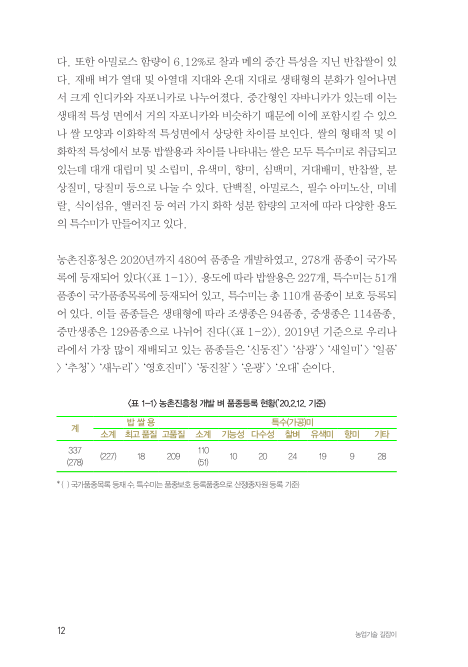

In [69]:
# page = doc.load_page(67)
# rects = page.cluster_drawings()
drawings = page.get_drawings()
rects = [d['rect'] for d in drawings]

# 페이지에 사각형 그리기
for rect in rects:
    page.draw_rect(rect, color=(0, 1, 0), width=1)  # 빨간색으로 사각형 그리기

# for d in drawings:
#     page.draw_rect(d['bbox'], color=(0, 1, 0), width=1)

# 노트북에서 바로 이미지 표시
from IPython.display import Image, display
pix = page.get_pixmap()
pix.save("temp_rect_image.png")
display(Image("temp_rect_image.png"))

In [31]:
doc.close()

In [85]:
page = doc.load_page(0)
text_info = page.get_text('dict')

In [ ]:
from collections import Counter
import fitz  # PyMuPDF

body_rect = fitz.Rect(0, 50, page.rect.width, page.rect.height - 50)

all_x_coords = []
for page in doc:
    # 본문 영역에 포함되는 블록만 필터링
    body_blocks = [b for b in page.get_text("blocks") if fitz.Rect(b[:4]).intersects(body_rect)]
    for block in body_blocks:
        # x0 좌표를 소수점 첫째 자리까지 반올림하여 그룹화
        all_x_coords.append(round(block[0], 1))

# 가장 흔한 x-좌표 2개 찾기
indent_counts = Counter(all_x_coords)
most_common_indents = indent_counts.most_common(2)

start_indent = None
continuation_indent = None

if len(most_common_indents) == 2:
    indent1, count1 = most_common_indents[0]
    indent2, count2 = most_common_indents[1]
    
    continuation_indent = min(indent1, indent2)
    start_indent = max(indent1, indent2)

elif len(most_common_indents) == 1:
    continuation_indent = most_common_indents[0][0]

return {"start": start_indent, "continuation": continuation_indent}

In [152]:
page = doc.load_page(8)

In [4]:
text_info = page.get_text('dict')

In [9]:
index = 0
for block in text_info['blocks']:
    if block['type'] == 0:
        # print(f'** block[bbox] **', block['bbox'])
        for line in block['lines']:
            for span in line['spans']:
                if index in (2, 3):
                    print(index)
                    # print(span['size'], span['font'], span['color'])
                    # print(span['text'])
                    print(span)



                index += 1
       

2
{'size': 9.746794700622559, 'flags': 4, 'bidi': 0, 'char_flags': 16, 'font': 'YDVYGOStd13', 'color': 2301728, 'alpha': 255, 'ascender': 0.8069999814033508, 'descender': -0.2809999883174896, 'text': '(1) 토양 양분 함량을 고려한 균형 시비', 'origin': (62.36220169067383, 73.51324462890625), 'bbox': (62.36220169067383, 65.44324493408203, 201.9362030029297, 76.3232421875)}
3
{'size': 10.889444351196289, 'flags': 4, 'bidi': 0, 'char_flags': 16, 'font': 'YDVYMjOStd12', 'color': 2301728, 'alpha': 255, 'ascender': 0.8029999732971191, 'descender': -0.2540000081062317, 'text': '일반적으로 시설 재배지에서는 다수확을 위해서 비료를 과다하게 많이 시용하는 ', 'origin': (62.36220169067383, 107.15325927734375), 'bbox': (62.36220169067383, 98.32025909423828, 400.6268310546875, 109.94725799560547)}


In [1]:
start_page = i
end_page = min(i + chunk_size, doc.page_count)

chunk_doc = fitz.open()
chunk_doc.insert_pdf(doc, from_page=start_page, to_page=end_page - 1)

pdf_chunk_bytes = chunk_doc.tobytes()
chunks.append((pdf_chunk_bytes, start_page))
chunk_doc.close()

NameError: name 'doc' is not defined

In [123]:
def get_s3_list(client, bucket_name, folder_prefix):
    response = client.list_objects_v2(
        Bucket=bucket_name,
        Prefix=folder_prefix,
        Delimiter='/'
    )
    return response


In [108]:
import boto3

# S3 클라이언트 생성
s3_client = boto3.client('s3')

# 버킷 이름과 폴더 경로 설정
bucket_name = 'gl-data-cdn-storage'
folder_prefix = 'farming_info/publicdata/'  # 슬래시(/)로 끝나야 함

# 폴더 리스트 가져오기
response = s3_client.list_objects_v2(
    Bucket=bucket_name,
    Prefix=folder_prefix,
    Delimiter='/'
)

# 결과 출력
print("폴더 목록:")
if 'CommonPrefixes' in response:
    for prefix in response['CommonPrefixes']:
        folder_name = prefix['Prefix'].split('/')[-2]  # 마지막 폴더 이름 추출
        print(f"- {folder_name}")
else:
    print("지정된 경로에 폴더가 없습니다.")


폴더 목록:
- chunk_배추_도표.pdf
- chunk_배추_사진
- chunked_배추.pdf
- image_test.pdf
- 농업기술길잡이_가지
- 농업기술길잡이_감
- 농업기술길잡이_감귤
- 농업기술길잡이_감자
- 농업기술길잡이_고구마
- 농업기술길잡이_고추
- 농업기술길잡이_가지
- 농업기술길잡이_감
- 농업기술길잡이_양파_107_115


In [116]:
print(response["CommonPrefixes"][5]['Prefix'])
print(response["CommonPrefixes"][-2]['Prefix'])


farming_info/publicdata/농업기술길잡이_감/
farming_info/publicdata/농업기술길잡이_감/


In [ ]:
import json
from fitz import Rect

with open('/Users/yoonhae/greenlabs/data-labs/experiments/engineering/pipelines/pdf-to-opensearch/output_v2/debug/all_elements_with_contents.json', 'r') as f:
    all_elements = json.load(f)

for element in all_elements:
    print(element['type'])
    print(element.get('content'))
    element['bbox'] = eval(element['bbox'])
    print(element['bbox'])
    print(element['page_index'])

In [194]:
types = []
for e in all_elements:
    if e['type'] not in types:
        types.append(e['type'])

print(types)

['etc', 'title', 'image', 'text', 'table']


In [ ]:

rebuild_all_elements = []
extra_text_elements = []
text_bbox_by_page = {}
prev_item = all_elements[0]

for i in range(1, len(all_elements)):
    item = all_elements[i]

    item_type = item.get('type')
    page_number = item.get('page_index', 'N/A')
    content = item.get('content', '')
    caption = item.get('caption', '')
    bbox = item.get('bbox', None)

    if page_number == 20:
        break

    if page_number not in text_bbox_by_page:
        min_x0 = float('inf')
        min_y0 = float('inf')
        max_x1 = float('-inf')
        max_y1 = float('-inf')
        for sub_item in range(i, len(all_elements)):
            if page_number == all_elements[sub_item].get('page_index', 'N/A'):
                if all_elements[sub_item].get('type') == 'text':
                    sub_item_bbox = all_elements[sub_item].get('bbox')

                    min_x0 = min(min_x0, sub_item_bbox.x0)
                    max_x1 = max(max_x1, sub_item_bbox.x1)
                    min_y0 = min(min_y0, sub_item_bbox.y0)
                    max_y1 = max(max_y1, sub_item_bbox.y1)
            else:
                break
        text_bbox_by_page[page_number] = (min_x0, min_y0, max_x1, max_y1)

    # 단이 나눠진 상태로 좌측, 우측에 각주들이 나열되는 경우가 있다. 메인 text 영역 외에 있는 text 는 각 페이지의 제대로 마무리된 text 하단에 모아서 배치한다.
    min_tect_x0, min_tect_y0, max_text_x1, max_text_y1 = text_bbox_by_page.get(page_number, (0, 0, 1000, 1000))
    if (bbox.x1 < min_tect_x0 or bbox.x0 > max_text_x1) and bbox.y0 >= min_tect_y0 and bbox.y1 <= max_text_y1:
        extra_text_elements.append(item)
        continue


    if item_type == prev_item['type'] and rebuild_all_elements:
        if item_type == 'text':
            if not prev_item['content'].rstrip().endswith(('.', '!', '?', '。', '！', '？')):
                rebuild_all_elements[-1]['content'] = rebuild_all_elements[-1]['content'] + content
                continue
        elif item_type == 'table' and prev_item.get('caption', '') == caption:
            rebuild_all_elements[-1]['content'] = rebuild_all_elements[-1]['content'] + "\n" + content
            continue

    if extra_text_elements:
        print(extra_text_elements)
        rebuild_all_elements.extend(extra_text_elements)
        extra_text_elements = []

    prev_item = item
    rebuild_all_elements.append(item)

[{'type': 'etc', 'page_index': 18, 'bbox': Rect(44.443199157714844, 504.8576965332031, 54.95930099487305, 513.4047241210938), 'content': 'Tip', 'sort_key': [18, 504.8576965332031]}, {'type': 'etc', 'page_index': 18, 'bbox': Rect(48.688621520996094, 517.313232421875, 131.95411682128906, 583.4512329101562), 'content': '덩이줄기 ● 영양소를 저장하기 위해 식물 의 일부가 변형되어 부피가 커 진 형태를 가리킨다. 감자는  씨앗을 심지 않고 이 덩이줄기 를 잘라 번식시킨다.', 'sort_key': [18, 517.313232421875]}]


In [ ]:
for item in rebuild_all_elements:
    print(item.get('content'))

In [51]:
from opensearch_loader import OpenSearchLoader

loader = OpenSearchLoader()

In [52]:
EMBEDDING_MODEL_ID = "cohere.embed-multilingual-v3"
EMBEDDING_DIMENSION = 1024
INDEX_NAME = "agri-kb-unified-vectors-dev-snapshot-20250716"



In [1]:
import glob

# md_files = glob.glob(os.path.join(directory_path, "*.md"))
chunk_file = "/Users/yoonhae/greenlabs/data-labs/.files/농업기술길잡이_가지_chunks.txt"
file_path = chunk_file


In [31]:
import re
import os

chunks = []
lines = []
try:
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
        
    lines = []
    page_number = None
    image_urls = []
    chunk_sequence = 1
    
    for line in content.split('\n'):
        line = line
        
        if line == '<chunk>':
            pass
        elif line == '</chunk>':
            if lines:
                chunk_data = {
                    'chunk_sequence': chunk_sequence,
                    'content': '\n'.join(lines)
                }
                
                if page_number:
                    chunk_data['page_number'] = page_number
                
                if image_urls:
                    chunk_data['image_urls'] = image_urls.copy()
                
                chunks.append(chunk_data)
                chunk_sequence += 1
                lines = []
                image_urls = []

        elif re.match(r'\[page_index:\s*(\d+)\]', line):
            page_number = int(re.match(r'\[page_index:\s*(\d+)\]', line).group(1)) + 1
        elif re.match(r'\[URL:\s*(.*?)\]', line):
            url = re.match(r'\[URL:\s*(.*?)\]', line).group(1)
            image_urls.append(url)
        else:
            lines.append(line)
except Exception as e:
    print(f"Error reading file {file_path}: {e}")

In [53]:
chunk_list = chunks
chunks[22]

{'chunk_sequence': 23,
 'content': '\n측지에서는 꽃눈이 분화된 바로 아래의 마디에서 나오는 세력이 강한 줄기에서 먼저 2~3매의 잎이 나온 다음 꽃이 분화되고, 그 후는 원줄기에서와 마찬가지로 2잎이 나오고 꽃이 하나씩 분화되어 나온다. 그 밑의 액아도 세력은 약하지만 점차 자라면서 같은 양상으로 꽃눈이 분화된다.\n## 다. 꽃의 종류\n가지의 정상화는 모든 기관이 잘 발달하여 대형이 되고 색깔이 진하며 꽃대가 길고 개화 당시에는 암술머리가 수술 선단부보다 길게 나온 것이 보통이다. 이 경우를 정상적인 장화주화라고 하는데, 암술머리가 보이지 않을 정도로 짧은 것은 단화주화라고 한다. 보통 암술이 짧아지는 경우 다른 기관의 발달도 나빠서 꽃은 소형이고 색깔이 담색이며 꽃줄기도 가늘고 씨방이 작다. 가지는 일반적으로 자가 수정을 하는데 아래로 향한 꽃의 수술에서 작은 구멍을 통하여 꽃가루가 비산하여 암술머리에 닫게 된다. 이 때문에 단화주화의 경우는 꽃가루를 받을 기회가 적어서 자연 수정이 되지 않아 낙화율이 높아진다.\n**그림: (그림 3-1) 가지 꽃의 종류**\n## 03\n## 환경 적응성\n## 가. 온도\n가지는 고온성 작물로서 생육 최적온도는 22~30℃이고 17℃ 이하가 되면 생육이 떨어지고 7~8℃ 이하가 되면 저온 피해를 입게 된다. 35~40℃ 정도가 되면 직접적인 고온 피해는 보이지 않지만 화기의 발육이 불량해지고 세력이 약해진다. ',
 'page_number': 30,
 'image_urls': ['https://ddht7b7vmidcm.cloudfront.net/farming_info/publicdata/농업기술길잡이_가지/page_28_chart_그림_3-1_가지_꽃의_종류_15.png']}

In [54]:
base_name = os.path.basename(file_path)
source_title = base_name.replace("_chunks.txt", "")
crop_name = source_title.replace("농업기술길잡이_", "")

In [56]:

from datetime import datetime, timezone
base_metadata = {
        "source_type": "PDF",
        "source_uri": "https://www.nongsaro.go.kr/portal/ps/psb/psbx/cropEbookMain.ps?menuId=PS65290",
        "source_title": f"농업기술길잡이-{crop_name}",
        "crop_name": crop_name,
        "created_at": datetime.now(timezone.utc).isoformat(),
    }

In [57]:

document_list = []

for i in range(0, len(chunk_list)):
    chunk = chunk_list[i]
    prev_chunk = chunk_list[i - 1] if i > 0 else None
    next_chunk = chunk_list[i + 1] if i < len(chunk_list) - 1 else None

    metadata = base_metadata.copy()
    metadata["chunk_sequence"] = chunk["chunk_sequence"]
    metadata["page_number"] = chunk["page_number"]

    if chunk.get("image_urls"):
        metadata["image_urls"] = chunk["image_urls"]
    
    current_document = {
        "metadata": metadata,
    }
    if prev_chunk:
        current_document["chunk_text_previous"] = prev_chunk['content']
    current_document["chunk_text_current"] = chunk['content']
    if next_chunk:
        current_document["chunk_text_next"] = next_chunk['content']

    document_list.append(current_document)



In [58]:
metadata_filter = {
    "source_type": "PDF",
    "source_uri": "https://www.nongsaro.go.kr/portal/ps/psb/psbx/cropEbookMain.ps?menuId=PS65290",
    "source_title": f"농업기술길잡이-{crop_name}",
}
deleted_count = loader.delete_documents_by_metadata(
    index_name=INDEX_NAME, metadata_filter=metadata_filter
)
print(f"-> API reported {deleted_count} documents for deletion.")

2025-08-04 13:09:21,977 - opensearch - INFO - POST https://vpc-fm-staging-search-6bg652xnejywwiwu5mbvp2y5qm.ap-northeast-2.es.amazonaws.com:443/agri-kb-unified-vectors-dev-snapshot-20250716/_delete_by_query [status:200 request:0.152s]
2025-08-04 13:09:21,978 - opensearch_loader - INFO - Deleted 0 documents from 'agri-kb-unified-vectors-dev-snapshot-20250716' matching filter.


-> API reported 0 documents for deletion.


In [ ]:


loader.insert_document_list(
    INDEX_NAME,
    document_list,
    embedding_model_id=EMBEDDING_MODEL_ID,
    embedding_dimension=EMBEDDING_DIMENSION,
    local_save_path="default",
    s3_save_path="default",
    batch_size=100
)

In [17]:
import glob
import os
import unicodedata

directory_path = "/Users/yoonhae/greenlabs/data-labs/.files/"
# directory_path = "/Users/yoonhae/greenlabs/data-labs/engineering/pipelines/pdf-to-opensearch/output_v2"
file_pattern = "*_chunks.txt"
chunk_files = glob.glob(os.path.join(directory_path, file_pattern))
sorted_chunk_files = sorted(chunk_files)

for file_path in sorted_chunk_files:
    print(file_path)
    new_file_path = unicodedata.normalize('NFC', file_path)
    if new_file_path != file_path:
        print(f"Normalized: {file_path} -> {new_file_path}")
        

/Users/yoonhae/greenlabs/data-labs/.files/농업기술길잡이_감귤_chunks.txt
Normalized: /Users/yoonhae/greenlabs/data-labs/.files/농업기술길잡이_감귤_chunks.txt -> /Users/yoonhae/greenlabs/data-labs/.files/농업기술길잡이_감귤_chunks.txt
/Users/yoonhae/greenlabs/data-labs/.files/농업기술길잡이_감자_chunks.txt
Normalized: /Users/yoonhae/greenlabs/data-labs/.files/농업기술길잡이_감자_chunks.txt -> /Users/yoonhae/greenlabs/data-labs/.files/농업기술길잡이_감자_chunks.txt
/Users/yoonhae/greenlabs/data-labs/.files/농업기술길잡이_고구마_chunks.txt
Normalized: /Users/yoonhae/greenlabs/data-labs/.files/농업기술길잡이_고구마_chunks.txt -> /Users/yoonhae/greenlabs/data-labs/.files/농업기술길잡이_고구마_chunks.txt
/Users/yoonhae/greenlabs/data-labs/.files/농업기술길잡이_가지_chunks.txt
/Users/yoonhae/greenlabs/data-labs/.files/농업기술길잡이_감_chunks.txt
/Users/yoonhae/greenlabs/data-labs/.files/농업기술길잡이_고추_chunks.txt
/Users/yoonhae/greenlabs/data-labs/.files/농업기술길잡이_당근_chunks.txt
/Users/yoonhae/greenlabs/data

In [14]:
from glob import glob
import unicodedata

dir_path = "/Users/yoonhae/greenlabs/data-labs/experiments/engineering/pipelines/pdf-to-opensearch/output_v2/"
pdf_files = sorted(glob(os.path.join(dir_path, "*.md")))
for file_path in pdf_files:
    base_name = os.path.splitext(os.path.basename(file_path))[0]
    new_file_path = unicodedata.normalize('NFC', file_path)
    if new_file_path != file_path:
        print(f"Normalized: {file_path} -> {new_file_path}")
        

Normalized: /Users/yoonhae/greenlabs/data-labs/experiments/engineering/pipelines/pdf-to-opensearch/output_v2/농업기술길잡이_가지.md -> /Users/yoonhae/greenlabs/data-labs/experiments/engineering/pipelines/pdf-to-opensearch/output_v2/농업기술길잡이_가지.md
Normalized: /Users/yoonhae/greenlabs/data-labs/experiments/engineering/pipelines/pdf-to-opensearch/output_v2/농업기술길잡이_감.md -> /Users/yoonhae/greenlabs/data-labs/experiments/engineering/pipelines/pdf-to-opensearch/output_v2/농업기술길잡이_감.md
Normalized: /Users/yoonhae/greenlabs/data-labs/experiments/engineering/pipelines/pdf-to-opensearch/output_v2/농업기술길잡이_감귤.md -> /Users/yoonhae/greenlabs/data-labs/experiments/engineering/pipelines/pdf-to-opensearch/output_v2/농업기술길잡이_감귤.md
Normalized: /Users/yoonhae/greenlabs/data-labs/experiments/engineering/pipelines/pdf-to-opensearch/output_v2/농업기술길잡이_감자.md -> /Users/yoonhae/greenlabs/data-labs/experiments/engineering/pipelines/pdf-to-opensearch/output_v2/농업기술길잡이_감